In [31]:
#Prog for AI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import mplfinance as mpf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [32]:
df = pd.read_csv("NFLX_daily_data.csv")

In [33]:
print("\nDisplaying the basic information of the dataset")
print(df.info())

print("\nDisplaying First 5 Rows of the dataset:")
print(df.head())
print("\nDisplaying the Summary Statistics of the dataset:")
print(df.describe())


Displaying the basic information of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5670 entries, 0 to 5669
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5670 non-null   object 
 1   Open       5670 non-null   float64
 2   High       5670 non-null   float64
 3   Low        5670 non-null   float64
 4   Close      5670 non-null   float64
 5   Adj Close  5670 non-null   float64
 6   Volume     5670 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 310.2+ KB
None

Displaying First 5 Rows of the dataset:
         Date      Open      High       Low     Close  Adj Close     Volume
0  2002-05-23  1.156429  1.242857  1.145714  1.196429   1.196429  104790000
1  2002-05-24  1.214286  1.225000  1.197143  1.210000   1.210000   11104800
2  2002-05-28  1.213571  1.232143  1.157143  1.157143   1.157143    6609400
3  2002-05-29  1.164286  1.164286  1.085714  1.103571   1.103571    675

In [34]:
print("\nChecking Missing Values in the dataset:")
print(df.isnull().sum())


Checking Missing Values in the dataset:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


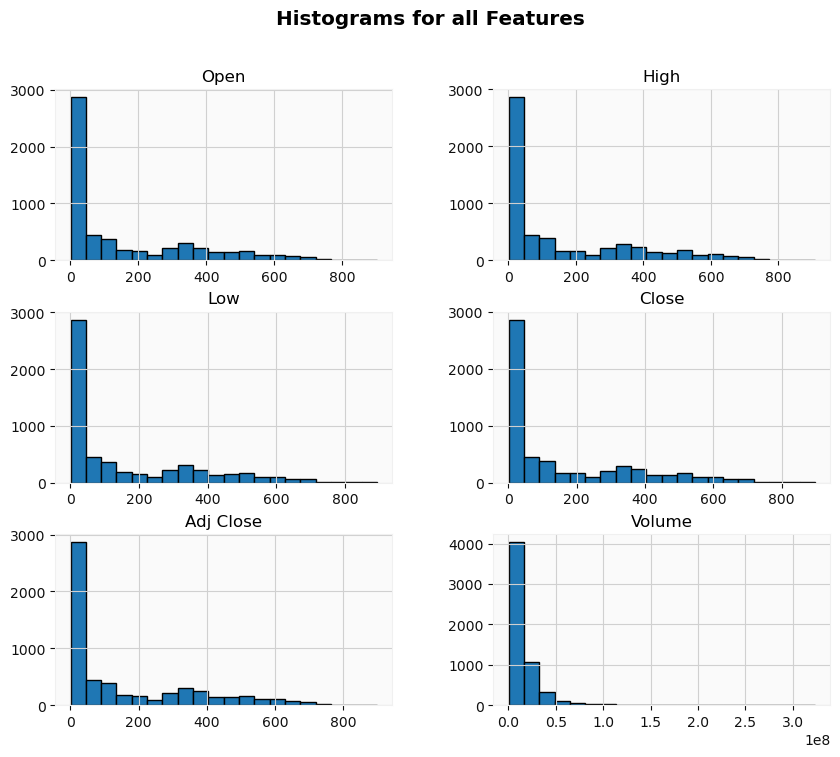

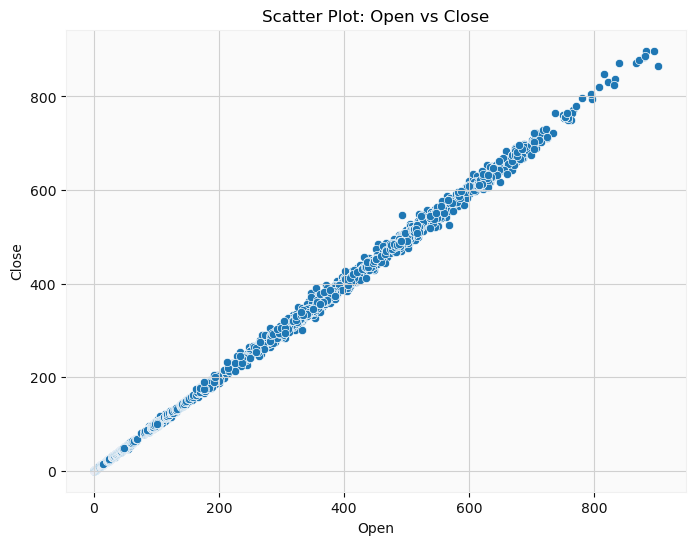

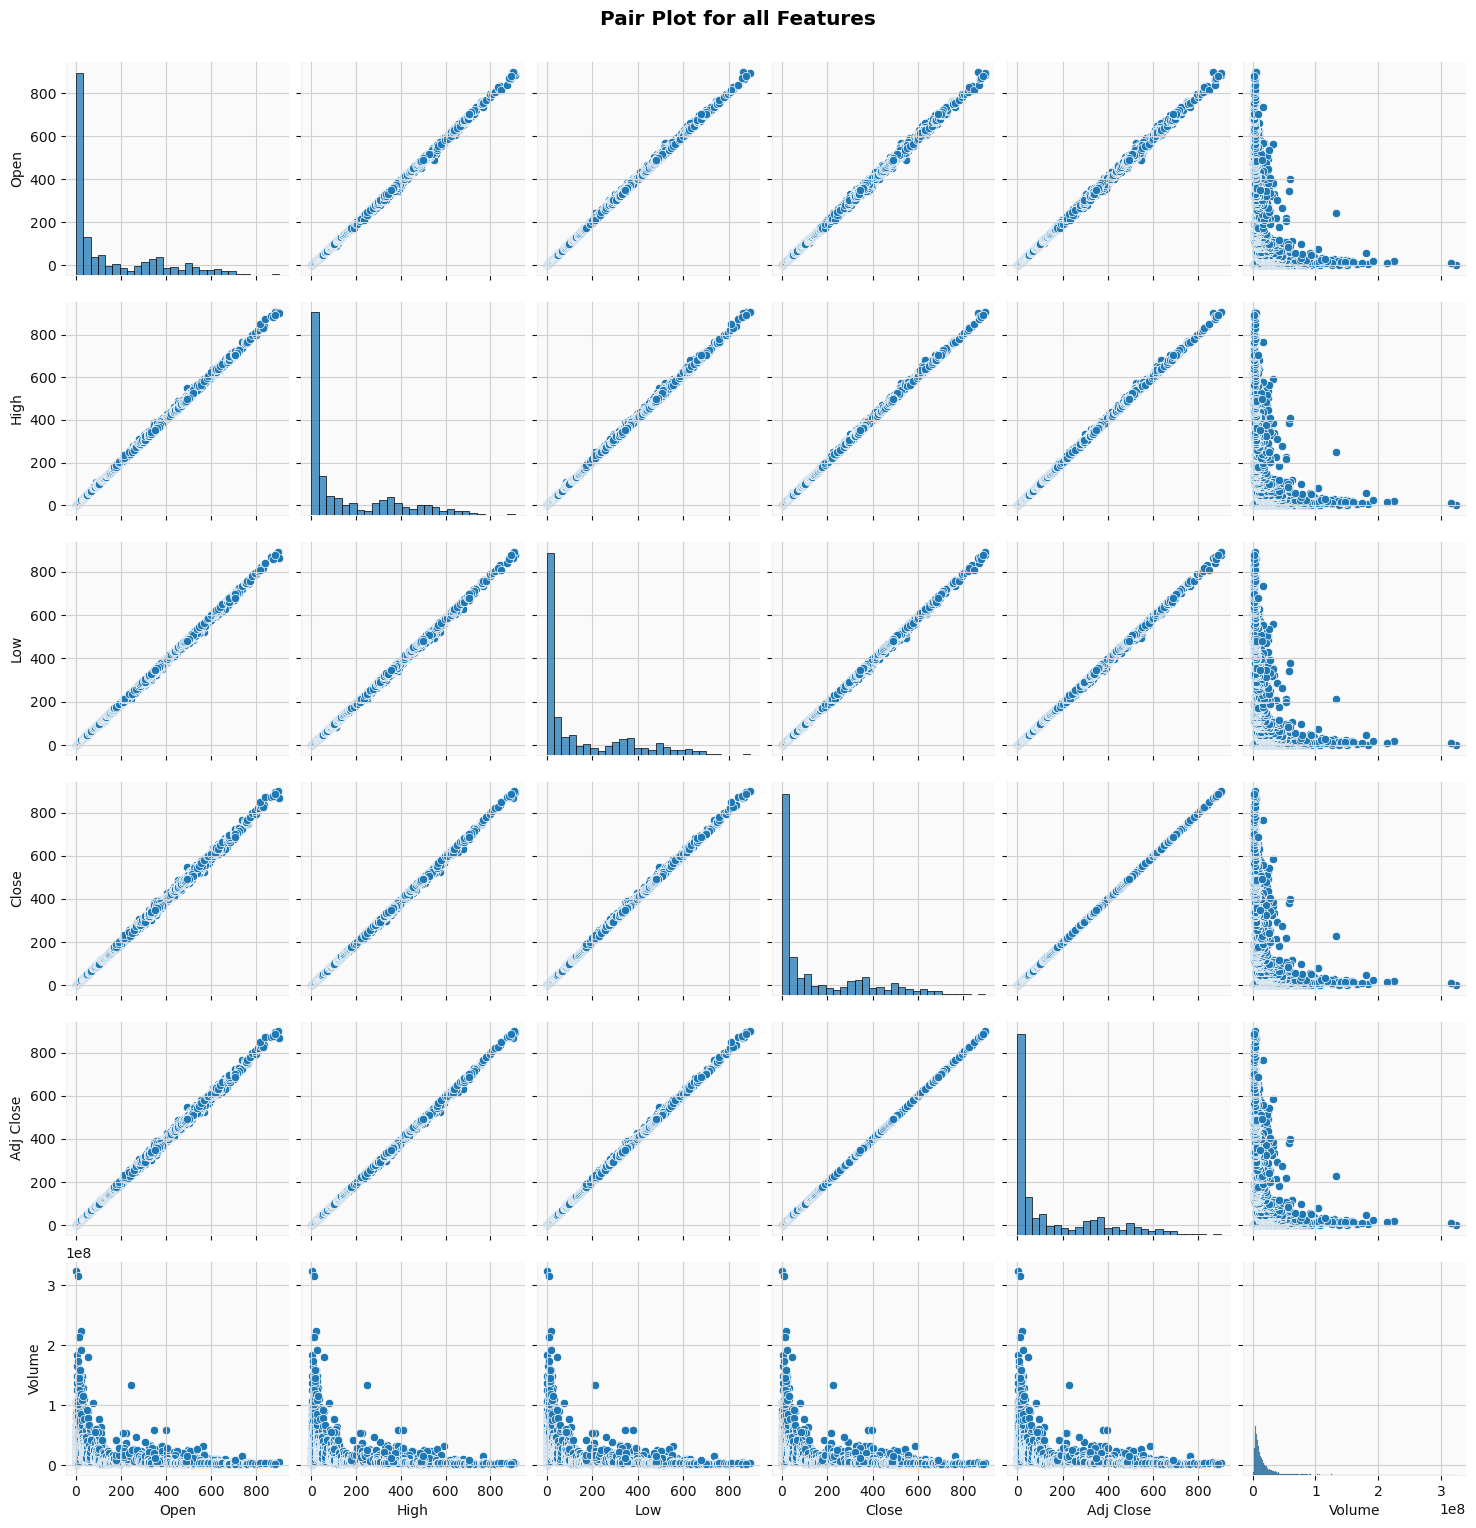

In [35]:
# Visualization

# 1. Histogram
df.hist(figsize=(10, 8), bins=20, edgecolor='black')
plt.suptitle('Histograms for all Features')
plt.show()


# 3. Scatter Plot (between two columns; customize as needed)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df.columns[1], y=df.columns[4], data=df)  # Replace column names if needed
plt.title(f'Scatter Plot: {df.columns[1]} vs {df.columns[4]}')
plt.show()

# 4. Pair Plot
sns.pairplot(df)
plt.suptitle('Pair Plot for all Features', y=1.02)
plt.show()

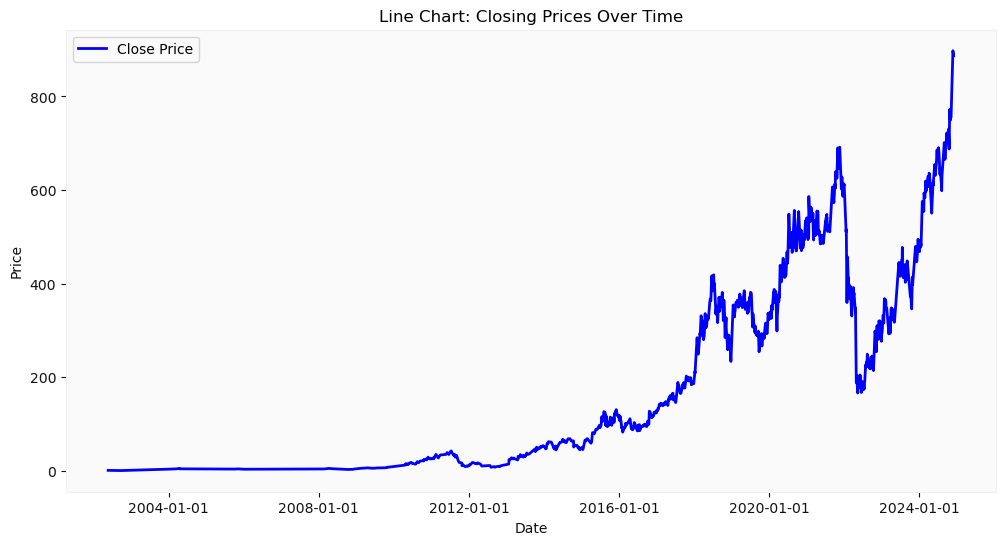

c:\Users\illiy\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


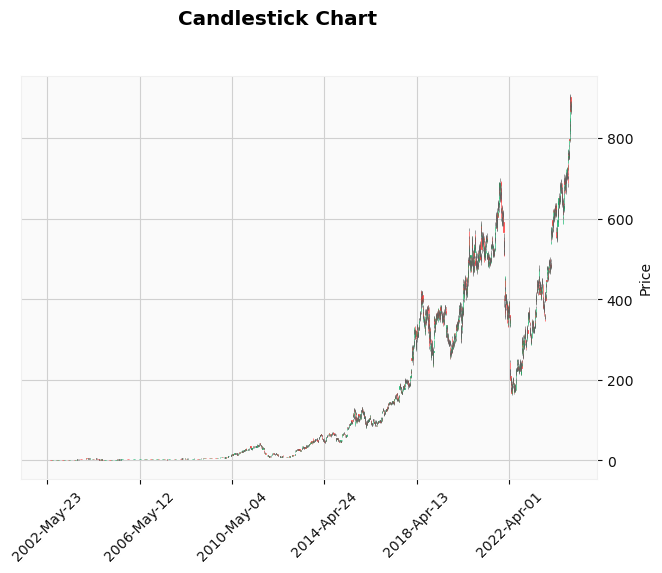

In [36]:



# Convert date column to datetime if it exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')  # Ensure data is sorted by date

# Line Chart
plt.figure(figsize=(12, 6))
if 'Date' in df.columns and 'Close' in df.columns:
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', linewidth=2)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  # Format x-axis as dates
else:
    print("Ensure the dataset has 'Date' and 'Close' columns for line chart.")
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Line Chart: Closing Prices Over Time')
plt.legend()
plt.grid()
plt.show()


# Candlestick Chart
# Ensure required columns exist for candlestick chart
required_columns = {'Date', 'Open', 'High', 'Low', 'Close'}
if required_columns.issubset(df.columns):
    candlestick_data = df[['Date', 'Open', 'High', 'Low', 'Close']].set_index('Date')
    mpf.plot(candlestick_data, type='candle', style='yahoo', title='Candlestick Chart', ylabel='Price')
else:
    #Error handling if the required column is present
    print(f"Ensure the dataset contains these columns for candlestick chart: {required_columns}")

6


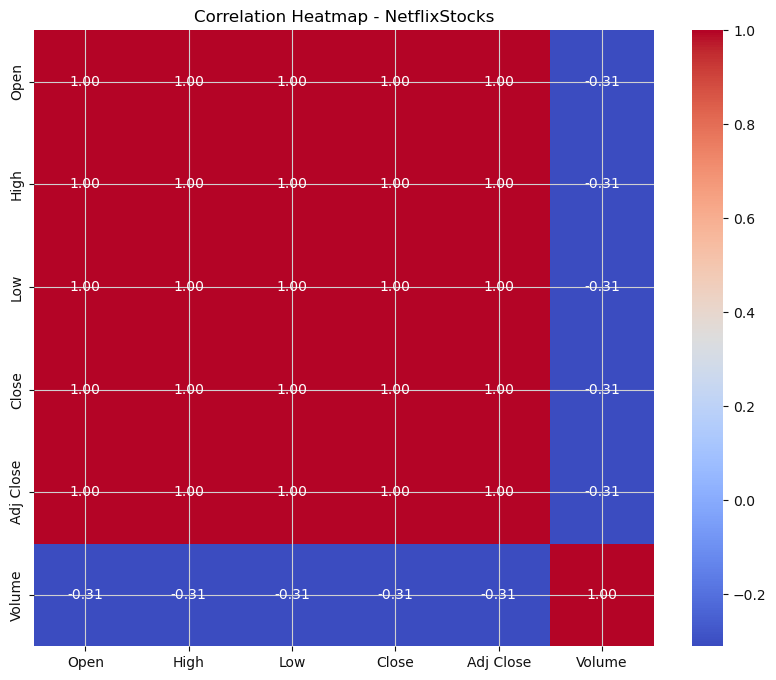

In [37]:
#As there are no missing values in the dataset, we do not need to modify the dataset by removing any rows or columns.
#We can proceed with the EDA(Exploratory Data Analytics)

columns_with_nums = df.select_dtypes(include=['float64', 'int64']).columns
print(len(columns_with_nums))
plt.figure(figsize=(10, 8))
sns.heatmap(df[columns_with_nums].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Correlation Heatmap - NetflixStocks")
plt.show()


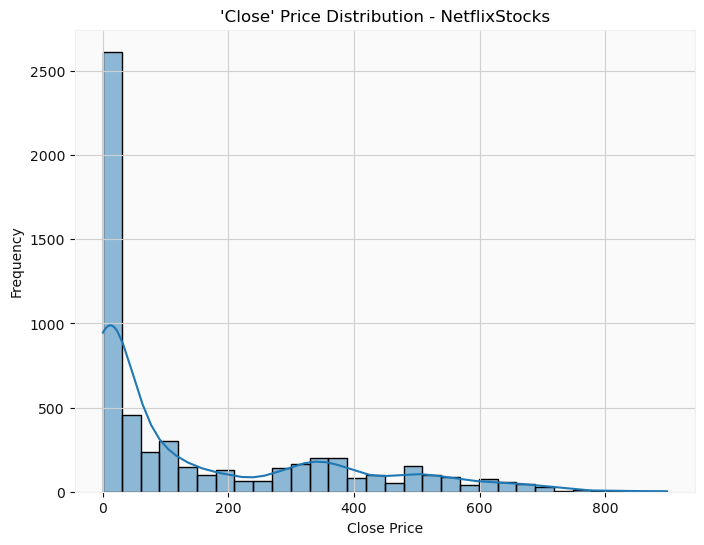

In [38]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Close'], kde=True, bins=30)
plt.title(f"'Close' Price Distribution - NetflixStocks")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

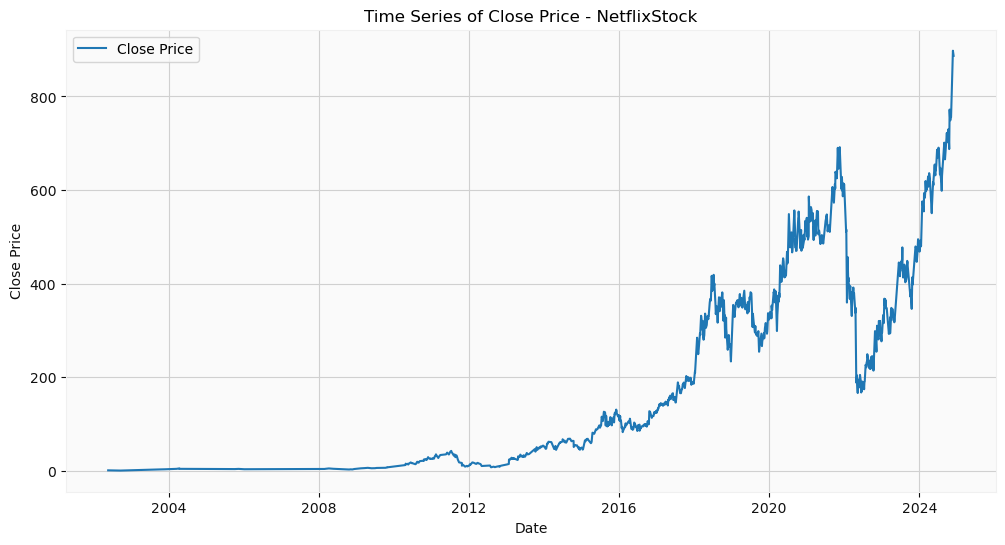

In [39]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
df = df.sort_values('Date')
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title(f"Time Series of Close Price - NetflixStock")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [40]:
#Now we can apply Some ML Algorithms to predict the "Adjusted Closing Values" of the stock prices.
#We will apply RandomForestClassifier model




# Convert Date column to datetime and sort by date

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)

# Normalize features for LSTM

scaler = MinMaxScaler()
scaled_dataframe = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])



# Create train-test split
X = scaled_dataframe[:-1, :]  # Use all features except the last day
y = scaled_dataframe[1:, 4]   # Use 'Adj Close' (scaled) as target, shifted by 1

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4535, 6), (1134, 6), (4535,), (1134,))

In [41]:
#RandomFOrestRegressor


# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)


# Evaluate the model using Mean Squared Error
rf_mse = mean_squared_error(y_test, rf_predictions)
print("\nMean Squared Error for RandomForestClassifier Model: ", rf_mse)




Mean Squared Error for RandomForestClassifier Model:  0.01761911246102543


In [42]:
#applying LSTM model


# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
lstm_predictions = lstm_model.predict(X_test_lstm)

# Evaluate the model using Mean Squared Error
lstm_mse = mean_squared_error(y_test, lstm_predictions)
print("\nMean Squared Error for LSTM Model: ",lstm_mse)

Epoch 1/20


c:\Users\illiy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0090
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2163e-04
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8764e-04
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3932e-04
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4568e-04
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3507e-04
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8909e-04
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8484e-04
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6561e-04
Epoch 10/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8610e-04
Epoch 11/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5987e-04
Epoch 12/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9931e-04
Epoch 13/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9970e-04
Epoch 14/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1298e-04
Epoch 15/20
142/

In [43]:
#Denormalizing Results
# Rescale predictions and actual values to original scale
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 5)), y_test.reshape(-1, 1))))[:, 5]
rf_predictions_actual = scaler.inverse_transform(np.hstack((np.zeros((rf_predictions.shape[0], 5)), rf_predictions.reshape(-1, 1))))[:, 5]
lstm_predictions_actual = scaler.inverse_transform(np.hstack((np.zeros((lstm_predictions.shape[0], 5)), lstm_predictions.reshape(-1, 1))))[:, 5]

# Print a few actual vs predicted values
print("\nSample Results:")
for i in range(5):
    print(f"Actual: {y_test_actual[i]:.2f}, RF Predicted: {rf_predictions_actual[i]:.2f}, LSTM Predicted: {lstm_predictions_actual[i]:.2f}")


Sample Results:
Actual: 153510191.51, RF Predicted: 150049386.16, LSTM Predicted: 148398687.00
Actual: 154010675.99, RF Predicted: 152676707.65, LSTM Predicted: 149995510.48
Actual: 152087930.78, RF Predicted: 152638289.00, LSTM Predicted: 150890501.26
Actual: 149337029.72, RF Predicted: 151022821.73, LSTM Predicted: 150105157.40
Actual: 151234578.74, RF Predicted: 150272124.01, LSTM Predicted: 148398975.90


In [44]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluation for Random Forest
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"Random Forest MAE: {rf_mae:.4f}")
print(f"Random Forest R^2 Score: {rf_r2:.4f}")

# Evaluation for LSTM
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM R^2 Score: {lstm_r2:.4f}")

# Print a few actual vs predicted values (after denormalizing)
print("\nSample Predictions (Denormalized):")
print(f"{'Actual':<15}{'RF Predicted':<15}{'LSTM Predicted'}")
for i in range(5):
    print(f"{y_test_actual[i]:<15.2f}{rf_predictions_actual[i]:<15.2f}{lstm_predictions_actual[i]:.2f}")

Random Forest MSE: 0.0176
Random Forest MAE: 0.0878
Random Forest R^2 Score: 0.3645
LSTM MSE: 0.0019
LSTM MAE: 0.0298
LSTM R^2 Score: 0.9304

Sample Predictions (Denormalized):
Actual         RF Predicted   LSTM Predicted
153510191.51   150049386.16   148398687.00
154010675.99   152676707.65   149995510.48
152087930.78   152638289.00   150890501.26
149337029.72   151022821.73   150105157.40
151234578.74   150272124.01   148398975.90


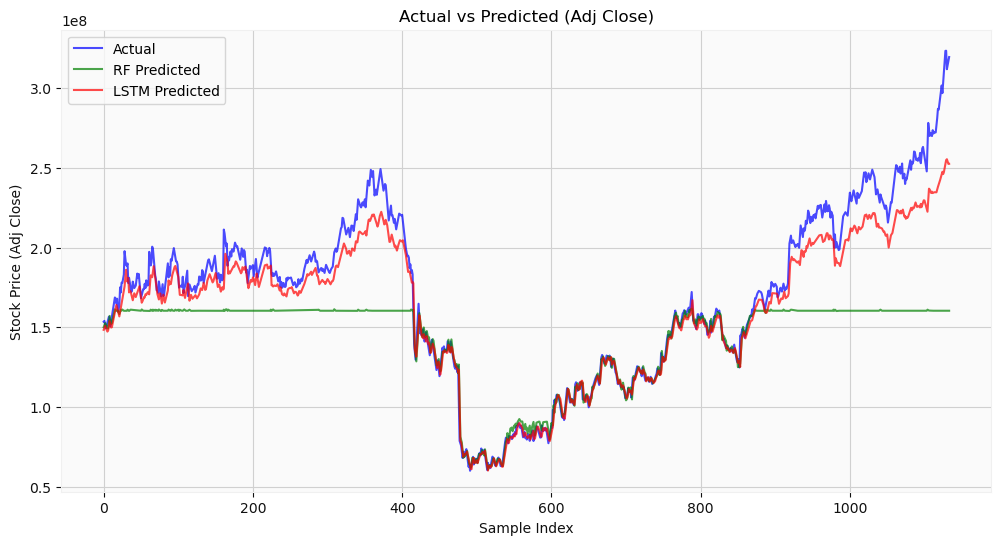

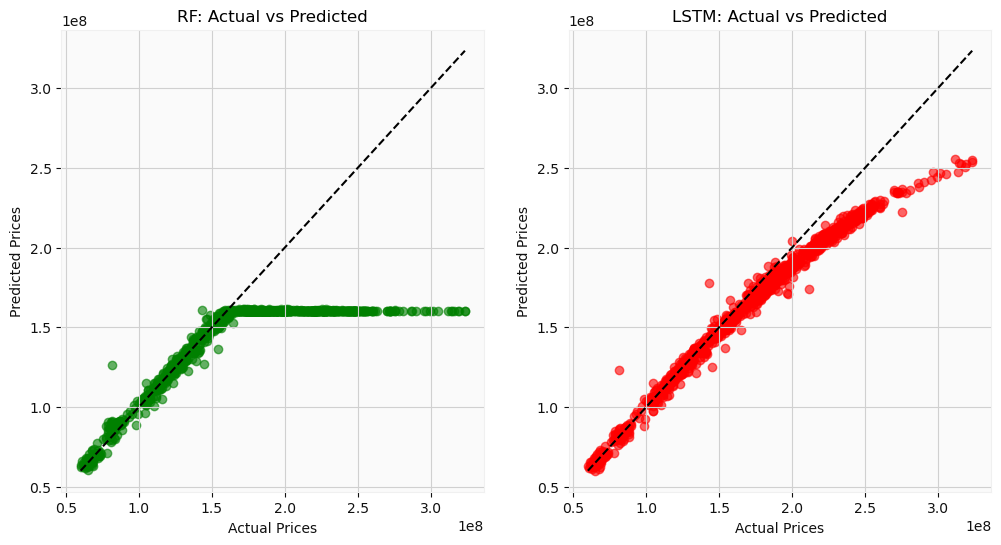

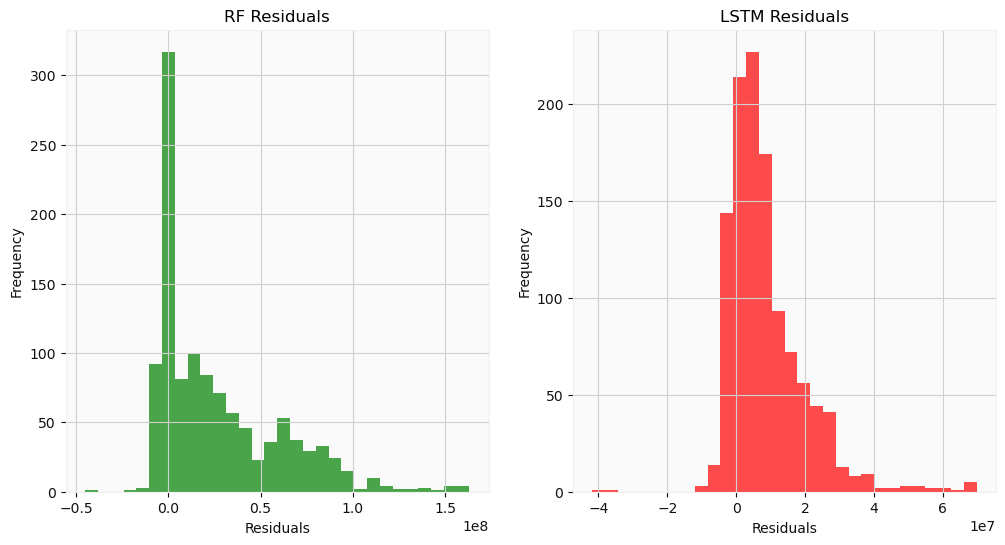

In [45]:

# ---------------- Evaluation and Visualization ----------------

# Plot: Actual vs Predicted (Line Plot)
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='blue', alpha=0.7)
plt.plot(rf_predictions_actual, label='RF Predicted', color='green', alpha=0.7)
plt.plot(lstm_predictions_actual, label='LSTM Predicted', color='red', alpha=0.7)
plt.title("Actual vs Predicted (Adj Close)")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price (Adj Close)")
plt.legend()
plt.show()

# Plot: Actual vs Predicted (Scatter Plot for RF and LSTM)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual, rf_predictions_actual, alpha=0.6, color='green')
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='black', linestyle='--')
plt.title("RF: Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

plt.subplot(1, 2, 2)
plt.scatter(y_test_actual, lstm_predictions_actual, alpha=0.6, color='red')
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='black', linestyle='--')
plt.title("LSTM: Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

# Plot: Residuals (Errors) for RF and LSTM
rf_residuals = y_test_actual - rf_predictions_actual
lstm_residuals = y_test_actual - lstm_predictions_actual

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(rf_residuals, bins=30, color='green', alpha=0.7)
plt.title("RF Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(lstm_residuals, bins=30, color='red', alpha=0.7)
plt.title("LSTM Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

19:15:52 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing


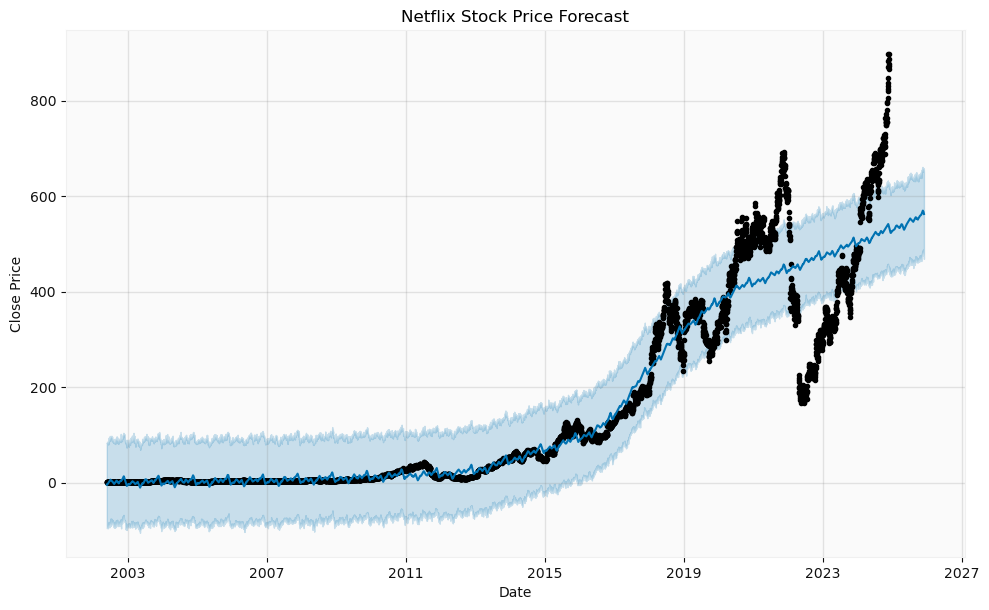

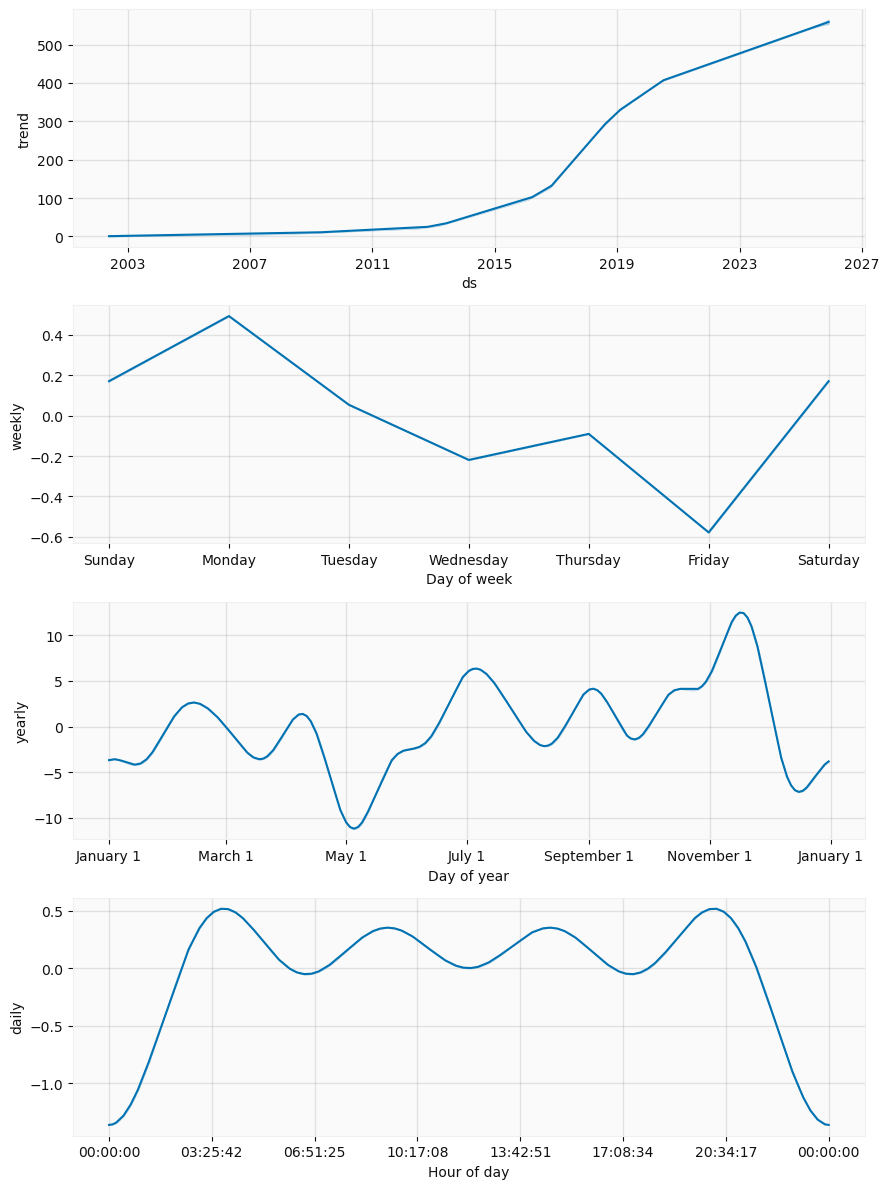

Forecast saved as netflix_forecast.csv


In [46]:

#prophet ML algo for future stock prediction...

from prophet import Prophet

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Prepare data for Prophet (rename columns to 'ds' and 'y')
prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize the Prophet model
model = Prophet(daily_seasonality=True)

# Fit the model to the data
model.fit(prophet_df)

# Make a dataframe for future predictions
# Let's predict the next 365 days
future = model.make_future_dataframe(periods=365)

# Generate predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Netflix Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Save forecast to a CSV file for review
forecast.to_csv('netflix_new_forecast.csv', index=False)
print("Forecast saved as netflix_forecast.csv")